In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import os
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import pandas as pd
df = pd.read_csv("/content/UNBER-1k.csv")
df

,reel_id,UnsafeType,Visual texts
0,www.facebook.com/reel/1000188341415358,Safe,Me on my way to watch Oppenheimer After Berbie
1,www.facebook.com/reel/1006146964533997,Safe,NaN
2,www.facebook.com/reel/1007123741459823,Adult,বান্ধবী আমার লাগানির পিনিকে আছে Love in love
3,www.facebook.com/reel/1007420607202244,Safe,প্রত্যেকটা অফিসে এমন একজন কলিগ থাকবেই Laptop
4,www.facebook.com/reel/1008519870870927,Safe,হ্যালো শার্ক ট্যাঙ্ক বাংলাদেশ আই এম কামিং
...,...,...,...
1112,www.facebook.com/reel/946250977507282,Suicidal,কিছু কথা বাকি ছিল আর হয়তো কোনদিনও বলা হবে না
1113,www.facebook.com/reel/951238780033589,Suicidal,তোমাকে মন দিয়ে ভালোবাসতাম উপহার হিসাবে তোমার ক...
1114,www.facebook.com/reel/974520454682213,Suicidal,ওগো শুনছো একথা বলা মানুষটা আজ অন্য কারোর।
1115,www.facebook.com/reel/975204184253727,Suicidal,"মন দিয়ে ভালোবাসতে গেলাম, অবশেষে ধোকা পেলাম।"


In [4]:
df['UnsafeType'], uniques = pd.factorize(df['UnsafeType'])
uniques

Index(['Safe', 'Adult', 'Harmful', 'Suicidal'], dtype='object')

In [5]:
dir = "/content/drive/MyDrive/UNBER-1k/Extracted_Features"

In [6]:
X = []
y = []

In [7]:
reels = []

for file in os.listdir(dir):
    if file.endswith(".npy"):
        file_path = os.path.join(dir, file)
        features = np.load(file_path)
        file_path = file_path.replace(".npy", "")
        file_path = file_path.replace(".wav", "")
        file_path = file_path.replace("/content/drive/MyDrive/UNBER-1k/Extracted_Features/audio", "www.facebook.com/reel/")
        if file_path in df['reel_id'].values:
          index = df.index[df['reel_id'] == file_path].tolist()[0]
          unsafe_type = df.loc[index, 'UnsafeType']
          y.append(unsafe_type)
          X.append(features)

In [8]:
X = np.array(X, dtype=np.float32)

In [9]:
X.shape

(1111, 21160)

In [10]:
y = np.array(y)
y.shape

(1111,)

In [11]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [12]:
X = np.expand_dims(X, axis=-1)

In [13]:
X.shape

(1111, 21160, 1)

In [14]:
import numpy as np

combined = list(zip(X, y))

np.random.shuffle(combined)

X, y = zip(*combined)

X = np.array(X)
y = np.array(y)

In [15]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)

In [16]:
yamnet_model = hub.load("https://tfhub.dev/google/yamnet/1")

In [17]:
def extract_yamnet_embeddings(features):
    features = tf.convert_to_tensor(features, dtype=tf.float32)
    features = tf.squeeze(features, axis=-1)  # Ensure it's 1D
    embeddings, _, _ = yamnet_model(features)
    return embeddings.numpy()

In [18]:
X_train_emb = np.array([extract_yamnet_embeddings(x) for x in X_train])
X_test_emb = np.array([extract_yamnet_embeddings(x) for x in X_test])
X_val_emb = np.array([extract_yamnet_embeddings(x) for x in X_val])

In [19]:
X_train_emb = X_train_emb.reshape(X_train_emb.shape[0], -1)
X_test_emb = X_test_emb.reshape(X_test_emb.shape[0], -1)
X_val_emb = X_val_emb.reshape(X_val_emb.shape[0], -1)

In [20]:
classifier = keras.Sequential([
    layers.Dense(64, activation="relu", input_shape=(X_train_emb.shape[1],)),
    layers.Dense(32, activation="relu"),
    layers.Dense(4, activation="softmax")  # 4-class classification
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
classifier.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00005),
                   loss="sparse_categorical_crossentropy",
                   metrics=["accuracy"])

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [23]:
classifier.fit(
    X_train_emb, y_train,
    epochs=200,
    batch_size=16,
    validation_data=(X_val_emb, y_val),
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.2623 - loss: 1.3845 - val_accuracy: 0.3820 - val_loss: 1.3783 - learning_rate: 5.0000e-05
Epoch 2/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3654 - loss: 1.3765 - val_accuracy: 0.3933 - val_loss: 1.3715 - learning_rate: 5.0000e-05
Epoch 3/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3746 - loss: 1.3727 - val_accuracy: 0.3989 - val_loss: 1.3641 - learning_rate: 5.0000e-05
Epoch 4/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3991 - loss: 1.3640 - val_accuracy: 0.3989 - val_loss: 1.3559 - learning_rate: 5.0000e-05
Epoch 5/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4032 - loss: 1.3546 - val_accuracy: 0.3989 - val_loss: 1.3475 - learning_rate: 5.0000e-05
Epoch 6/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4111 - loss: 1.3462 - val_accuracy: 0.3989 - val_loss: 1.3385 - learning_rate: 5.0000e-05
Epoch 7/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3856

In [24]:
y_pred = classifier.predict(X_test_emb)
y_pred_classes = np.argmax(y_pred, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


In [25]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.40      1.00      0.57        18
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00         5

    accuracy                           0.40        45
   macro avg       0.10      0.25      0.14        45
weighted avg       0.16      0.40      0.23        45



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


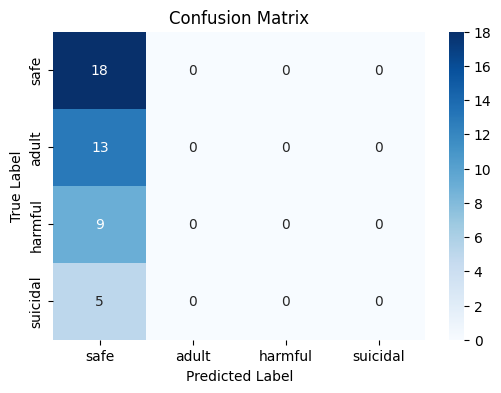

In [26]:
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 4))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["safe","adult","harmful","suicidal"], yticklabels=["safe","adult","harmful","suicidal"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.show()

In [28]:
# prompt: save the trained model in a given directory

# Assuming you want to save the trained 'classifier' model.
model_save_path = "/content/drive/MyDrive/UNBER-1k/Models/ReelYAMNet.keras" #@param {type:"string"}
classifier.save(model_save_path)
print(f"Model saved to: {model_save_path}")


Model saved to: /content/drive/MyDrive/UNBER-1k/Models/ReelYAMNet.keras
